In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import math
import random
import itertools
import datetime
from pytz import timezone
from sklearn.utils import shuffle

%matplotlib inline

Load preprocessed dataframes.

In [4]:
#Open our hdf files
validate_store = pd.HDFStore('data/combined_day1_processed.h5')
pos_store1 = pd.HDFStore('data/processed/day1_positives_processed.h5')
neg_store1 = pd.HDFStore('data/processed/day1_negatives_processed.h5')
pos_store2 = pd.HDFStore('data/processed/day2_positives_processed.h5')
neg_store2 = pd.HDFStore('data/processed/day2_negatives_processed.h5')

#Load out dataframes
df_validate = validate_store['df']
df_pos1 = pos_store1['df'] 
df_neg1 = neg_store1['df']
df_pos2 = pos_store2['df'] 
df_neg2 = neg_store2['df']

#Close our hdf files
validate_store.close()
pos_store1.close()
neg_store1.close()
pos_store2.close()
neg_store2.close()

#Shuffle dataframes
df_validate = shuffle(df_validate)
df_pos = shuffle(pd.concat([df_pos1, df_pos2]))
df_neg = shuffle(pd.concat([df_neg1, df_neg2]))

In [5]:
# SAMPLE_SIZE = min(df_pos.shape[0], df_neg.shape[0], 70000)
SAMPLE_SIZE = 70000

In [6]:
df_train = pd.concat([df_pos.sample(int(0.5*SAMPLE_SIZE)), df_neg.sample(int(0.5*SAMPLE_SIZE))])
df_train = shuffle(df_train)
# df_test = shuffle(df_test.sample(int(0.3 * SAMPLE_SIZE)))
df_test = shuffle(df_validate.sample(30000))
df_test.shape

(30000, 39)

In [7]:
df_train.columns

Index(['_host', 'ad_network_id', 'advertiser_id', 'c_cnt', 'c_flag_cnt',
       'campaign_id', 'campaign_type', 'f_cnt', 'geo_city_name',
       'geo_country_code3', 'geo_region_name', 'geo_timezone', 'i_cnt',
       'i_flag_cnt', 'i_timestamp', 'pub_network_id', 'r_cnt',
       'r_num_ads_requested', 'r_num_ads_returned', 'r_timestamp',
       'rate_metric', 'referer', 'session_id', 'site_id', 'token', 'ua',
       'ua_device', 'ua_device_type', 'ua_major', 'ua_minor', 'ua_os_name',
       'url', 'user_agent', 'uuid', 'vi_cnt', 'vi_flag_cnt', 'url_domain',
       'red_domain', 'keywords'],
      dtype='object')

In [8]:
cols_to_drop = ['c_flag_cnt', 'i_cnt', 'i_flag_cnt', 'i_timestamp', 'vi_cnt', 'vi_flag_cnt']
df_train.drop(cols_to_drop, inplace=True, axis=1, errors='ignore')
df_test.drop(cols_to_drop, inplace=True, axis=1, errors='ignore')
df_train.columns

Index(['_host', 'ad_network_id', 'advertiser_id', 'c_cnt', 'campaign_id',
       'campaign_type', 'f_cnt', 'geo_city_name', 'geo_country_code3',
       'geo_region_name', 'geo_timezone', 'pub_network_id', 'r_cnt',
       'r_num_ads_requested', 'r_num_ads_returned', 'r_timestamp',
       'rate_metric', 'referer', 'session_id', 'site_id', 'token', 'ua',
       'ua_device', 'ua_device_type', 'ua_major', 'ua_minor', 'ua_os_name',
       'url', 'user_agent', 'uuid', 'url_domain', 'red_domain', 'keywords'],
      dtype='object')

In [9]:
print(df_train.shape)
print(df_test.shape)
df_train.head()

(70000, 33)
(30000, 33)


,_host,ad_network_id,advertiser_id,c_cnt,campaign_id,campaign_type,f_cnt,geo_city_name,geo_country_code3,geo_region_name,...,ua_device_type,ua_major,ua_minor,ua_os_name,url,user_agent,uuid,url_domain,red_domain,keywords
594384,an-prod-ralphie-frontline-kaiak.us-east-1,1341.0,3577.0,0.0,18192.0,private,0.0,Andover,USA,KS,...,PC,16.0,16299.0,Windows 10,http://www.thegatewaypundit.com/2018/04/organi...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,05f8c845-16ed-4875-b273-be1c2a992c44,www.thegatewaypundit.com,www.thegatewaypundit.com,"[organizers, illegal, migrant, caravan, headed..."
299448,an-prod-ralphie-frontline-fleck.eu-west-1,1173.0,3224.0,1.0,14468.0,rtb,0.0,Ulyanovsk,RUS,81,...,MOB,11.0,2.0,iOS,,Viber/8.5.0.6 CFNetwork/894 Darwin/17.4.0,340EB9DB-CAA9-4F4D-9377-474D56F2CF23,,,[]
313653,an-prod-ralphie-frontline-scall.eu-west-1,734.0,3483.0,0.0,24019.0,third-party,1.0,Nizhniy Novgorod,RUS,51,...,PC,11.0,0.0,Windows 10,,Mozilla/5.0 (compatible; pycurl),337ca0d2cbc6008f2086a88ab6fa5087ba706e1b,,,[]
442531,an-prod-ralphie-frontline-slain.eu-west-1,734.0,4315.0,1.0,26882.0,outside,0.0,Varazdin,HRV,16,...,MOB,11.0,3.0,iOS,,Viber/8.6.0.65 CFNetwork/897.15 Darwin/17.5.0,0D2A73E6-F287-4A2B-8F07-46FB1B7ABEEE,,,[]
228048,an-prod-ralphie-frontline-egret.eu-west-1,734.0,4315.0,1.0,26884.0,outside,0.0,Tgls,HUN,10,...,MOB,63.0,0.0,Android,,Dalvik/2.1.0 (Linux; U; Android 8.0.0; TA-1024...,97438d7d-7923-440d-9af9-e7365e821667,,,[]


## One hot encoding of categorical data

In [10]:
import pickle

In [11]:
OHE_PATH = "data/ohe_labels.pkl"

In [12]:
#this is the helper function for preprocessing ohe labels - dont need to explicitly call this function
def generate_ohe_labels(df, c, thresh=200, k_most_freq=False):
    appears, oh_index = {}, {}
    if c == 'keywords':
        for val in df[c].values:
            for word in val:
                if word not in appears:
                    appears[word] = 0
                appears[word] += 1
        if k_most_freq:
            for v in sorted(appears)[0:thresh]:
                oh_index[v] = len(oh_index)
        else:
            for v in [k for k in appears.keys()]:
                if appears[v] < thresh:
                    del appears[v]
            for v in sorted(appears):
                oh_index[v] = len(oh_index)
    else:    
        for val in df[c].values:
            if val not in appears:
                appears[val] = 0
            appears[val] += 1
        if k_most_freq:
            for v in sorted(appears)[0:thresh]:
                oh_index[v] = len(oh_index)
        else:
            for v in [k for k in appears.keys()]:
                if appears[v] < thresh:
                    del appears[v]
            for v in sorted(appears):
                oh_index[v] = len(oh_index)
    return oh_index

#generate OHE labels to be used for batch learning - run this FIRST
def preprocess_ohe(df, thresh=200, path=OHE_PATH, k_most_freq=False):
    #create and save our ohe labels
    ohe_labels = {}
    for c in df:
        if c == 'c_cnt':
            continue
        else:
            ohe_labels[c] = generate_ohe_labels(df, c, thresh, k_most_freq=k_most_freq)

    with open(path, 'wb') as f:
        pickle.dump(ohe_labels, f, pickle.HIGHEST_PROTOCOL)
        
    return ohe_labels
        
#generates a small X and Y matrix by sampling from both negative and positive dataframes
def generate_batch(df_pos, df_neg, batch_size, path=OHE_PATH, pos_ratio=1, ohe_labels=None):
    #load our ohe labels
    if ohe_labels == None:
        with open(path, 'rb') as f:
            ohe_labels = pickle.load(path)
    
    #pick which indices to use for our batch training
    indices_touse_pos = np.random.permutation(len(df_pos))[0:batch_size]
    indices_touse_neg = np.random.permutation(len(df_neg))[0:int(batch_size*pos_ratio)]
    
    #generate X and Y matrices
    X, Y = [], []
    for i in range(batch_size):
        sample_x, sample_y = generate_one_sample(df_pos, ohe_labels)
        X.append(sample_x)
        Y.append(sample_y)
    for i in range(int(batch_size*pos_ratio)):
        sample_x, sample_y = generate_one_sample(df_neg, ohe_labels)
        X.append(sample_x)
        Y.append(sample_y)
    
    #shuffle X and Y matrices
    shuffled_indices = np.random.permutation(len(X))
    return [X[i] for i in shuffled_indices], [Y[i] for i in shuffled_indices]
    
#generates exactly one random sample from a dataframe using OHE. this is a helper function, shouldn't be explicitly called
#if index is not -1, will not generate random index
def generate_one_sample(df, ohe_labels, index=-1):
    if index == -1:
        index = np.random.randint(0,len(df))
    X = [[0 if ohe_labels[c][df[c].values[index]] != j else 1 for j in range(len(ohe_labels[c]))]
         if df[c].values[index] in ohe_labels[c] else [0 for j in range(len(ohe_labels[c]))]
                  for c in ohe_labels if c != 'c_cnt' and c != 'keywords']
    wordset = set([w for w in df['keywords'].values[index]])
    X.append([1 if v in wordset else 0 for v in ohe_labels['keywords']])
    X = np.array(X)
    X = np.hstack(X)
    return X, df['c_cnt'].values[index]

#takes in the dataframe, returns an X and Y matrix 
def transform_df(df, ohe_labels):
    X, Y = [], []
    for i in range(len(df)):
        xmini, ymini = generate_one_sample(df, ohe_labels, index=i)
        X.append(xmini)
        Y.append(ymini)
    return X, Y

#generate ohe labels
# ohe_labels = preprocess_ohe(df_neg, k_most_freq=False)
#get validation set - take first 100,000 samples of both
# df_validate = pd.concat([df_neg.head(100000), df_pos.head(100000)])
# df_pos = df_pos.tail(len(df_pos)-100000)
# df_neg = df_neg.tail(len(df_neg)-100000)


'''If you wanted to do one hot encoding for k most frequent classes - use this code
ohe_labels = preprocess_ohe(df_neg, thresh=k, k_most_freq=True)
X, Y = transform_df(df, ohe_labels)
'''

'If you wanted to do one hot encoding for k most frequent classes - use this code\nohe_labels = preprocess_ohe(df_neg, thresh=k, k_most_freq=True)\nX, Y = transform_df(df, ohe_labels)\n'

In [13]:
ohe_labels = preprocess_ohe(df_train, thresh=20, k_most_freq=True)
print("ohe labels done")
X_train, Y_train = transform_df(df_train, ohe_labels)
print("training set done")
X_test, Y_test = transform_df(df_test, ohe_labels)
print("test set done")

ohe labels done
training set done
test set done


In [14]:
X_train, Y_train = pd.DataFrame(X_train), pd.DataFrame(Y_train)
X_test, Y_test = pd.DataFrame(X_test), pd.DataFrame(Y_test)

## Validation functions

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

def validate(model, df_validate):
    sigmoid = lambda x: 1/(1+2.71828**(-1*x))
    Y_test, Y_pred, Y_prob = [], [], []
    #Separate the validation dataframe into batches of 100
    for i in range(int(len(df_validate)/100)):
        X, Y = [], []
        for j in range(i*100,(i+1)*100):
            miniX, miniY = generate_one_sample(df_validate, ohe_labels, index=j)
            X.append(miniX)
            Y.append(miniY)
        Y_test.extend(Y)
        Y_pred.extend(model.predict(X))
        Y_prob.extend(model.decision_function(X))
    #apply sigmoid activation to all decision function values
    Y_prob = [sigmoid(i) for i in Y_prob]
    #get class probabilities based on Y_predict and Y_prob
    Y_prob = [[1-p, p] for i, p in enumerate(Y_prob)]
    #get log loss
    logloss = log_loss(Y_test, Y_prob)
    test_cm = confusion_matrix(Y_test, Y_pred)
    
    return logloss, test_cm

model = SGDClassifier(loss='log',penalty='l1',alpha=0.1)
X, Y = generate_batch(df_pos, df_neg, 100, ohe_labels=ohe_labels)
model.partial_fit(X, Y, classes=[0, 1])
for i in range(10000):
    X, Y = generate_batch(df_pos, df_neg, 100, ohe_labels=ohe_labels)
    if i % 10 == 0 and i != 0:
        train_cm = confusion_matrix(Y, model.predict(X))
        print("iteration ", i, "with training score ", model.score(X,Y))
        print("Training confusion matrix:")
        print(train_cm)
    if i % 10 == 0 and i != 0:
        logloss, test_cm = validate(model, df_validate)
        print("Log loss score: ", logloss)
        print("Test confusion matrix:")
        print(test_cm)
    model.partial_fit(X, Y)

NameError: name 'confusion_matrix' is not defined

## Scoring Functions

In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
'''
We will be using f1 score to measure our models, which is a good performance measurement scalar for datasets
where the negatives >> positives.
'''
def get_f1_score(test_cm):
    true_neg  = test_cm[0][0]
    false_pos = test_cm[0][1]
    false_neg = test_cm[1][0]
    true_pos  = test_cm[1][1]
    precision = true_pos/(true_pos+false_pos)
    recall = true_pos/(true_pos+false_neg)
    if precision + recall == 0: return 0
    score = 2*precision*recall/(precision+recall)
    return score

'''
Returns (precision, recall)
'''
def cm_score(cm): 
    tn, fp, fn, tp = cm.ravel()
    return tp/(tp+fp), tp/(tp+fn)

## Random forest classifier to rank importance of numerical featuers

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
X, Y = generate_batch(df_pos, df_neg, 1000, ohe_labels=ohe_labels)
rfc = RandomForestClassifier()
rfc.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
X_train, Y_train = pd.DataFrame(X), pd.DataFrame(Y)

In [32]:
importances = rfc.feature_importances_
indices = np.argsort(importances)
print([list(ohe_labels.keys())[i] for i in indices])

IndexError: list index out of range

## XGBoost

In [17]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import log_loss

In [72]:
df_biased = shuffle(pd.concat([df_pos.sample(int(0.1*SAMPLE_SIZE)), df_neg.sample(int(0.9*SAMPLE_SIZE))]))

In [73]:
X_biased, Y_biased = transform_df(df_biased, ohe_labels)

In [89]:
X_biased, Y_biased = pd.DataFrame(X_biased), pd.DataFrame(Y_biased)

In [76]:
dbiased = xgb.DMatrix(X_biased, label=Y_biased)

In [90]:
X_biased.head()

,0,1,2,3,4,5,6,7,8,9,...,579,580,581,582,583,584,585,586,587,588
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
X, Y = generate_batch(df_pos, df_neg, 7000, ohe_labels=ohe_labels, pos_ratio=0.5)
X_train_eq, Y_train_eq = pd.DataFrame(X), pd.DataFrame(Y)

X, Y = generate_batch(df_pos, df_neg, 7000, ohe_labels=ohe_labels, pos_ratio=0.1)
X_train_biased, Y_train_biased  = pd.DataFrame(X), pd.DataFrame(Y)

X, Y = generate_batch(df_pos, df_neg, 3000, ohe_labels=ohe_labels, pos_ratio=0.1)
X_test_biased, Y_test_biased  = pd.DataFrame(X), pd.DataFrame(Y)

X, Y = generate_batch(df_pos, df_neg, 3000, ohe_labels=ohe_labels, pos_ratio=(df_test.c_cnt.sum())/(len(df_test.c_cnt)))
X_test_same, Y_test_same  = pd.DataFrame(X), pd.DataFrame(Y)

In [37]:
dtrain_eq = xgb.DMatrix(X_train_eq, label=Y_train_eq)
dtrain_biased = xgb.DMatrix(X_train_biased, label=Y_train_biased)
dtest_biased = xgb.DMatrix(X_test_biased)
dtest_same = xgb.DMatrix(X_test_same)

In [18]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test)

In [40]:
# model: XGB model
# dtest: dmatrix (if XGB native model) or DataFrame (if sklearn api model)
# Y_test: Pandas Series of correct values
def score_xgboost(model, dtest, Y_test):
    prediction_thresh = 0.15 #np.round(model.predict(dtest)))
    cm = confusion_matrix(Y_test, [1 if x >= prediction_thresh else 0 for x in model.predict(dtest)])
    tn, fp, fn, tp = cm.ravel()
    precision, recall = tp/(tp+fp), tp/(tp+fn)
    print(cm)
    print("Y positive ratio: ", float(Y_test.sum() / len(Y_test)))
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("logloss: ", log_loss(Y_test, model.predict(dtest)))
    print("f1 score: ", get_f1_score(cm))
    print("positive accuracy: ", tp/(tp + fn))
    print("negative accuracy: ", tn/(tn + fp))


In [52]:
# params = {'max_depth':6, 'eta':0.3, 'objective':'binary:logistic', 
#           'subsample':0.5, 'min_child_weight':3, 'gamma':5, 
#           'max_delta_step':2, 'eval_metric':'logloss'}
# params = {'max_depth':6, 'eta':0.3, 'silent':1, 'objective':'binary:logistic',
#           'subsample':0.5,'min_child_weight':3, 'gamma': 5, 'max_delta_step':2,
#           'scale_pos_weight':(len(df_test.c_cnt) - df_test.c_cnt.sum())/(df_test.c_cnt.sum())}
num_rounds = 200
# params = {'max_depth':6, 'eta':0.3, 'silent':1, 'objective':'binary:logistic',
#           'subsample':0.5,'min_child_weight':3, 'gamma': 5,
#           'scale_pos_weight':10000}
# num_rounds = 150
params={'eta':0.2}

In [36]:
# # XGBboost batch training
# X, Y = generate_batch(df_pos, df_neg, 1000, ohe_labels=ohe_labels)
# X, Y = pd.DataFrame(X), pd.DataFrame(Y)
# dmatrix = xgb.DMatrix(X, label=Y)
# model = xgb.train(params, dmatrix, num_boost_round=num_rounds)
# for i in range(num_rounds, 1000):
#     print("iteration: ", i)
#     X, Y = generate_batch(df_pos, df_neg, 100, ohe_labels=ohe_labels)
#     X, Y = pd.DataFrame(X), pd.DataFrame(Y)
#     dmatrix = xgb.DMatrix(X, label=Y)
#     model.update(dmatrix, i)
# score_xgboost(model, dtest, Y_test)

[[21325  8658]
 [    3    14]]
Y positive ratio:  0.0005666666666666667
Precision:  0.0016143911439114391
Recall:  0.8235294117647058
logloss:  1.118451977837207
f1 score:  0.0032224651858671883


In [34]:
num_rounds = 50
params = {'max_depth':5, 'eta':0.25, 'objective':'binary:logistic',
          'subsample':0.1, 'max_delta_step':8, 'min_child_weight':20, 'gamma':20}
params={'max_depth':5,'objective':'binary:logistic', 'eta':0.25, 'max_delta_step':8, 'min_child_weight':20, 'gamma':20}
# params={'objective':'binary:logistic'}

In [35]:
model = xgb.train(params, dtrain, num_boost_round=num_rounds)

In [41]:
# without counts
print(model.predict(dtest))
score_xgboost(model, dtest, Y_test)

[0.20086172 0.05809835 0.05400364 ... 0.20086172 0.09909448 0.06024683]
[[25021  4959]
 [   12     8]]
Y positive ratio:  0.0006666666666666666
Precision:  0.0016106301590497283
Recall:  0.4
logloss:  0.09637816922596346
f1 score:  0.003208341688389814
positive accuracy:  0.4
negative accuracy:  0.8345897264843228


In [42]:
tn, fp, fn, tp = [28728, 1253, 10, 9]

In [43]:
print("positive accuracy: ", tp/(tp + fn))
print("negative accuracy: ", tn/(tn + fp))

positive accuracy:  0.47368421052631576
negative accuracy:  0.9582068643474201


In [53]:
#with counts
print(model.predict(dtest))
score_xgboost(model, dtest, Y_test)

[0.0641287  0.4207093  0.07158999 ... 0.0641287  0.7447072  0.0641287 ]
[[28728  1253]
 [   10     9]]
Y positive ratio:  0.0006333333333333333
Precision:  0.0071315372424722665
Recall:  0.47368421052631576
logloss:  0.17648345293700696
f1 score:  0.01405152224824356
positive accuracy:  0.47368421052631576
negative accuracy:  0.9582068643474201


In [350]:
print(model.predict(dtest))
score_xgboost(model, dtest, Y_test)

[0.06502938 0.06502938 0.06502938 ... 0.06502938 0.06502938 0.06502938]
[[20822   166]
 [   10     2]]
Y positive ratio:  0.0005714285714285715
Precision:  0.011904761904761904
Recall:  0.16666666666666666
logloss:  0.12425036974322229
f1 score:  0.022222222222222223
positive accuracy:  4.783315794508753e-05
negative accuracy:  0.4979910073663063


In [50]:
score_xgboost(model, dtest, Y_test)

[[19372  1616]
 [    7     5]]
Y positive ratio:  0.0005714285714285715
Precision:  0.0030845157310302285
Recall:  0.4166666666666667
logloss:  inf
f1 score:  0.00612369871402327


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1769: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [47]:
score_xgboost(model, dtest, Y_test)

[[18484  2504]
 [    7     5]]
Y positive ratio:  0.0005714285714285715
Precision:  0.0019928258270227183
Recall:  0.4166666666666667
logloss:  0.2539656011788895
f1 score:  0.0039666798889329636


In [40]:
xgb_eq = xgb.train(params, dtrain_eq, num_boost_round=num_rounds)

In [45]:
score_xgboost(xgb_eq, dtest, Y_test)

[[19590  1398]
 [    8     4]]
Y positive ratio:  0.0005714285714285715
Precision:  0.0028530670470756064
Recall:  0.3333333333333333
logloss:  0.1557951823147568
f1 score:  0.005657708628005658


In [41]:
xgb_biased = xgb.train(params, dtrain_biased, num_boost_round=num_rounds)

In [46]:
score_xgboost(xgb_biased, dtest, Y_test)

[[17646  3342]
 [    7     5]]
Y positive ratio:  0.0005714285714285715
Precision:  0.0014938751120406335
Recall:  0.4166666666666667
logloss:  0.3924755790859816
f1 score:  0.002977076510866329


In [54]:
# clf_eq = xgb.XGBClassifier().fit(X_train_eq, Y_train_eq)

In [55]:
# clf_biased = xgb.XGBClassifier().fit(X_train_biased, Y_train_biased)

Hey, so I'll just summarize my results here. So firstly I sampled from the processed positives and negatives for my training set and used the combined day 1 for my test set. One huge problem I encountered is that I wasn't able to one hot encode the whole training or test set (or more than 100,000 rows) because the new one hot encoding function is really slow. Just looking at Activity Monitor, the memory the process consumes increases very slowly, whereas sklearn's categorical encoder is much faster. Maybe i didn't wait long enough, but i waited for about 20 min and there was less than a 2GB in memory consumption by python. So I think we should maybe switch back to the previous one, which uses sklearn's categorical encoder, to OHE and try to make some optimizations.

For my datasets, I used the generate_batch to train on sets of 7,000 samples. I created balanced and biased datasets, where balanced has positive ratio of 0.5 and biased has positive ratio of 0.1. My test set was a batch of 3,000 samples from the combined_day1 with positive ratio equal to the empirical pos ratio of combined_day1. 

For XGBoost, I tried both the default XGBoost Booster model with the .train method, and tried the XGBClassifier model (which is an sklearn api). For both, I trained models on both the balanced and biased sets and then evaluated on the empirical set. Basically, the XGBClassifier is slow to train and not very good compared to the Booster model. The Booster model with default parameters gets about 2% precision and 100% recall (for both balanced and biased), so it's most likely overfitting. I read the docs and adjusted the parameters a bit, and the biased model (with positive ratio 10%) got 17% precision and 100% recall, and this was on only 10,000 samples. I think that on more samples and with more hyperparameter tuning it can be a lot better, since it still is likely overfitting. Even though it was only 17% precision, seems like a huge improvement over the previous model since I only changed like 2 hyperparameters. 

In [178]:
# print("XGB booster with equal pos/neg training set:")
# print("Biased test set:")
# score_xgboost(xgb_eq, dtest_biased, Y_test_biased)
# print("Empirical test set:")
# score_xgboost(xgb_eq, dtest_same, Y_test_same)
# print()
# print("XGB booster with biased pos_ratio=0.1 training set:")
# print("Biased test set:")
# score_xgboost(xgb_biased, dtest_biased, Y_test_biased)
# print("Empirical test set:")
# score_xgboost(xgb_biased, dtest_same, Y_test_same)
# print()
# print("XGB Classifier with equal pos/neg training set:")
# print("Biased test set:")
# score_xgboost(clf_eq, X_test_biased, Y_test_biased)
# print("Empirical test set:")
# score_xgboost(clf_eq, X_test_same, Y_test_same)
# print()
# print("XGB Classifier with biased pos/neg training set:")
# print("Biased test set:")
# score_xgboost(clf_biased, X_test_biased, Y_test_biased)
# print("Empirical test set:")
# score_xgboost(clf_biased, X_test_same, Y_test_same)

XGB booster with equal pos/neg training set:
Biased test set:
[[2650   56]
 [  12  282]]
Y positive ratio:  0.098
Precision:  0.834319526627219
Recall:  0.9591836734693877
Empirical test set:
[[2942   56]
 [   0    1]]
Y positive ratio:  0.00033344448149383126
Precision:  0.017543859649122806
Recall:  1.0

XGB booster with biased pos_ratio=0.1 training set:
Biased test set:
[[2691   15]
 [  22  272]]
Y positive ratio:  0.098
Precision:  0.9477351916376306
Recall:  0.9251700680272109
Empirical test set:
[[2987   11]
 [   0    1]]
Y positive ratio:  0.00033344448149383126
Precision:  0.08333333333333333
Recall:  1.0

XGB Classifier with equal pos/neg training set:
Biased test set:
[[2598  108]
 [  17  277]]
Y positive ratio:  0.098
Precision:  0.7194805194805195
Recall:  0.9421768707482994
Empirical test set:
[[2896  102]
 [   0    1]]
Y positive ratio:  0.00033344448149383126
Precision:  0.009708737864077669
Recall:  1.0

XGB Classifier with biased pos/neg training set:
Biased test set:

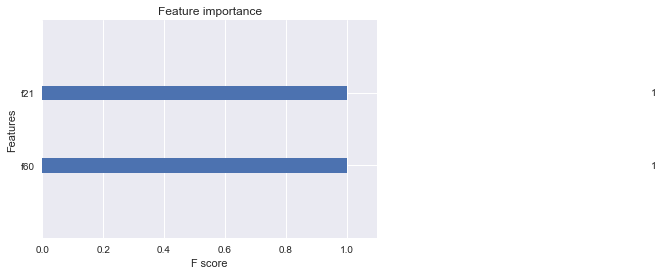

In [116]:
plot_importance(xgb_eq)

In [ ]:
plot_importance(xgb_biased)

In [ ]:
plot_importance(clf_eq)

In [ ]:
plot_importance(clf_biased)

In [109]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(penalty='l2', C=0.1, solver='newton-cg', multi_class='ovr', max_iter=500)
lr.fit(X_train, y_train)

In [119]:
train_cm = confusion_matrix(y_train, lr.predict(X_train))
train_precision, train_recall = cm_score(train_cm)
print(train_cm)
print(train_precision)
print(train_recall)

test_cm = confusion_matrix(y_test, lr.predict(X_test))
test_precision, test_recall = cm_score(test_cm)
print(test_cm)
print(test_precision)
print(test_recall)

# print(get_f1_score(test_cm))

KeyboardInterrupt: 